---
authors:
  - name: Anderson Liew 
    affiliation: University of Washington
    email: jeanliew@uw.edu
    github: 
    linkedin: https://www.linkedin.com/in/anderson-liew-ab44b0206/
---

# Real Estate Asset Price Correlation

This project examines real estate asset prices and analyzes how variables such as proximity to public transportation and amenities like convenience stores affect property value, respectively, with respect to age and price. I'll use methods from statistical hypothesis testing, such as t-tests and p-value significance, to confirm findings, and machine learning, such as XGBoost, to build a regression model to predict prices based on given factors.

### Research Questions
1. How much does housing proximity to the metro (MRT) change real estate prices?
   - I'll quantify the prices of houses closer to MRT and those further away and estimate the marginal price change per unit of distance.
2. Does the age of real estate moderate the effect of transit access on price?
   - I'll test and see if newer houses are more or less sensitive in pricing when compared to proximity to the MRT.
3. How do neighborhood context variables relate to housing prices after accounting for MRT proximity and age?
   - I'll include other variables that serve as "community amenities" in my original metro proximity comparison with age and compare them to find if there's any correlating effect.

## Motivation

As an international student from Taiwan, this dataset is the perfect opportunity to determine if public transportation truly has a substantial effect on housing prices. Especially in larger cities like Taipei, it's strongly believed that they do, and this project would help me understand more than just the assumptions made by the general public. Having a trustworthy source of data and evidence to back up this finding would help affirm the presumptions made.

## Data Setting

Dataset: Real Estate Valuation  
Source: https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set

Columns used:
- X1 transaction date (year.fraction) -> `date`
- X2 house age (years) -> `age_yrs`
- X3 distance to nearest MRT (meters) -> `mrt_m`
- X4 number of convenience stores -> `stores`
- X5 latitude -> `lat`
- X6 longitude -> `lon`
- Y house price of unit area (10,000 NTD per Ping) -> `price_ping`

Potential Complications:
- Location differences: Some locations are pricier because of the school or area, which could downplay the public transportation proximity effect.
- Time changes: Different years in the dataset require accounting for inflation if using all years.
- Unconventional units: "Ping" is a standard unit measurement used in some Asian countries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
def load_real_estate(path):
    df = pd.read_csv(path)
    df = df.rename(columns={
        'X1 transaction date': 'date',
        'X2 house age': 'age_yrs',
        'X3 distance to the nearest MRT station': 'mrt_m',
        'X4 number of convenience stores': 'stores',
        'X5 latitude': 'lat',
        'X6 longitude': 'lon',
        'Y house price of unit area': 'price_ping'
    })
    
    df = df[['date', 'age_yrs', 'mrt_m', 'stores', 'lat', 'lon', 'price_ping']]
    return df

df = load_real_estate('real_estate_eval.csv')
df

,date,age_yrs,mrt_m,stores,lat,lon,price_ping
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [3]:
df.isnull().sum()

date          0
age_yrs       0
mrt_m         0
stores        0
lat           0
lon           0
price_ping    0
dtype: int64

In [4]:
df.describe()

,date,age_yrs,mrt_m,stores,lat,lon,price_ping
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


## Method

### Data Loading and Preparation

I used load_real_estate(path) to read the CSV and renamed the columns to shorter names: `date`, `age_yrs`, `mrt_m`, `stores`, `lat`, `lon`, `price_ping`. These are the only columns I kept from the original dataset.

### Exploratory Data Analysis

I first examined the dataset structure to understand what the rows and columns represent and confirmed there's no missing data.

I identified which variables relate to each research question:
- `price_ping` is my outcome variable
- `mrt_m` addresses my first research question about transit proximity
- `age_yrs` addresses my second research question about age moderation
- `stores` addresses my third research question about neighborhood amenities
- `lat`, `lon`, and date are control variables

I ran df.describe() to get summaries for all the quantitative variables and wrote up what those numbers mean for my research questions. This helped me understand the typical ranges and distributions before modeling.

For visualizations, I created three plots (plotting functions):
- Scatter plot showing MRT distance vs price -> shows the overall negative relationship for research question 1
- Scatter plot with age vs price, colored by MRT distance -> shows how age and MRT interact for research question 2
- Box plot comparing price distributions across different store counts -> shows public amenities' effect for research question 3

### Statistical Hypothesis Testing (Challenge Goal 1)

I will use statistical tests to validate my findings:
- Pearson correlation test to confirm MRT distance significantly affects prices (addresses research question 1)
- Compared correlations between newer and older houses to see if age moderates the MRT effect (addresses research question 2)
- Independent t-test to see if store counts significantly affect prices (addresses research question 3)

### Make Simple Features From Columns 

I'll create make_features(df) that adds:
- price_log = log(price_ping)
- mrt_log = log1p(mrt_m)
- year = int(date)

Testing: Small test to check when mrt_m = 0, then mrt_log is also 0, and exp(mean(price_log)) is around the geometric mean of price_ping.

Log transformations will help normalize the price and distance distributions for better model performance.

### Split the Data for Checking 

I'll use split_xy(df, test_size=0.2) to create train and validation sets (X_tr, X_va, y_tr, y_va).
- Features for X are: mrt_log, age_yrs, stores, lat, lon, year
- Target for y is: price_log

Testing: Small test to make sure price_log isn't in X.

This split lets me train the model on 80% of data and evaluate performance on the other 20%.

### Modeling with XGBoost (Challenge Goal 2)

I'll use train_xgb(X_tr, y_tr, X_va, y_va) to fit an XGBRegressor with objective="reg:squarederror" and then try different parameter combinations for n_estimators to find the best fit.

Testing: Small test on a table where price_log decreases as mrt_log increases, and training runs with validation error dropping initially.

XGBoost will capture non-linear relationships and interactions between variables, helping quantify how much each factor has an effect on prices.

### Evaluate How Good the Model Is 

I'll use evaluate(model, X_va, y_va) that returns a dict with RMSE, MAE, and R-squared metrics.

Testing: Small test to check if R-squared is above 0.7, so I know if the model is good enough to be trustworthy.

## EDA Results

**What steps did you take during your EDA that prepared the work you conducted for the rest of your analysis?**
I started by loading and cleaning the dataset, checking for missing values, and confirming that all seven columns were usable. Then I summarized the data using df.describe() to see basic statistical values. After that, I made three plots to look at how MRT distance, age, and store counts relate to price. These helped me figure out which tests and variables were worth focusing on later when I start modeling and testing hypotheses.

**What did you learn about your data from doing the EDA?**
I learned that the dataset was already clean, which made it easy to work with. Prices  dropped as MRT distance increased, and newer houses tended to be priced higher. I also saw that areas with more convenience stores usually had higher prices, showing that location and public amenities both matter.

**How did your understanding of the data setting change?**
At first, I thought MRT proximity alone would explain most price changes. But after exploring the data, I realized that housing age and local amenities also play a big role. I also understood that the dataset only covers a short time frame, so price differences mostly come from location rather than housing market changes over time.

### How large is your dataset

The real estate evaluation dataset that I chose for this project has 414 rows and 7 columns. Each row represents a single property transaction, and each column describes a specific feature about that property. The columns are:

`date`: transaction date

`age_yrs`: age of the house in years

`mrt_m`: distance to the nearest MRT station in meters

`stores`: number of convenience stores nearby

`lat`: latitude

`lon`: longitude

`price_ping`: house price per unit area, measured in 10,000 NTD per ping

### Does your dataset have any missing data?

I checked for missing values in all columns and confirmed there weren't any using df.isnull().sum() under the Data Setting category above this section. 

### What are the variables of interest for your research question?

`price_ping`: dependent variable representing housing price

`mrt_m`: independent variable for Research Question 1 about transit proximity

`age_yrs`: variable for Research Question 2 about how age affects the MRT effect

`stores`: variable for Research Question 3 about neighborhood amenities

Others like `lat`, `lon`, and `date` are control variables to help provide context.

### Give a summary of each variable of interest.

To understand the data structure and range, I used df.describe() to generate a summary under the Data Setting category above this section.

### Create at least 2 visualizations

I created 3 visualizations based on each of my research topics below in the Results category under this section.

### Result validity only

**Research Question 1: How much does housing proximity to the metro (MRT) change real estate prices?**

Null Hypothesis: There is no correlation between MRT distance and price (p = 0)

Alternative Hypothesis: MRT distance and price are correlated (p /= 0)

Test: Pearson correlation

Assumptions:

* The relationship between MRT distance and price is roughly linear.
* Each house sale is an independent observation.
* The sample size is large enough so normality doesn’t matter much.

Verification:
The scatter plot plot_mrt_vs_price(df) shows that prices go down as MRT distance increases, which looks like a clear negative line. Each data point is a different house, so independence makes sense. There are 414 total rows, which is enough data to assume normality.

**Research Question 2: Does the age of real estate moderate the effect of transit access on price?**

Null Hypothesis: The correlation between MRT distance and price is the same for newer houses (age < 15) and older houses (age >= 15)

Alternative Hypothesis: The correlation between MRT distance and price is different between newer and older houses

Test: Compare correlation values for two groups

Assumptions:

* Both newer and older groups have roughly linear trends.
* The two groups don’t overlap and are independent.
* The sample size is large enough so normality doesn’t matter much.

Verification:
The scatter plot plot_age_price_mrt(df) shows that newer and older houses both have negative trends between MRT distance and price, but the slopes look a bit different. That means the correlation might change by age. The data points are all separate houses, so independence is fine, and both groups have enough houses for the test.

## Results

**TODO**: *Replace this text with your results. Be sure to create new code cells and new Markdown text cells with additional subheadings to explain and break-up longer snippets of code into a more readable format.*

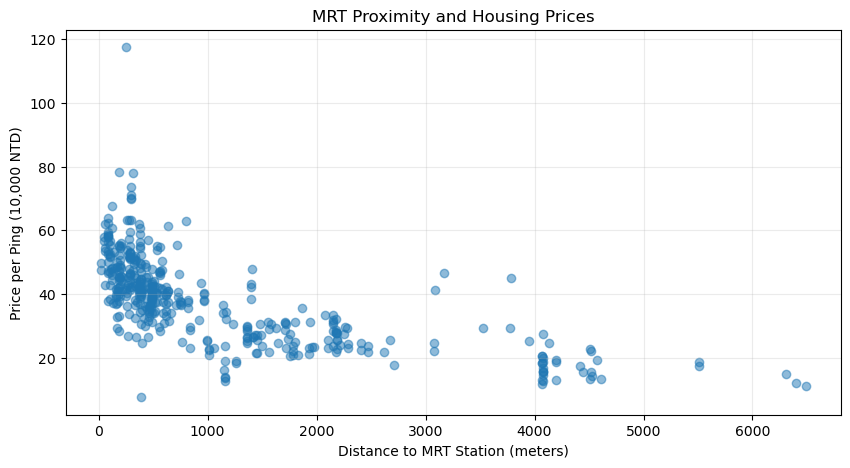

In [5]:
def plot_mrt_vs_price(df):
    """
    This function takes in real estate data to return
    a scatter plot comparing MRT distance vs housing price.
    """
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.scatter(df['mrt_m'], df['price_ping'], alpha = 0.5)
    ax.set_xlabel('Distance to MRT Station (meters)')
    ax.set_ylabel('Price per Ping (10,000 NTD)')
    ax.set_title('MRT Proximity and Housing Prices')
    ax.grid(True, alpha = 0.25)
    plt.show()
    return ax

ax = plot_mrt_vs_price(df)
assert len(ax.collections) == 1, "Expected one scatter plot"
assert ax.get_xlabel() == 'Distance to MRT Station (meters)', "x label mismatch"
assert ax.get_ylabel() == 'Price per Ping (10,000 NTD)', "y label mismatch"
assert ax.get_title() == 'MRT Proximity and Housing Prices', "title mismatch"

**Caption:** Houses closer to MRT stations have higher prices, showing a clear negative relationship between distance and property value.

**Alt text:** Scatter plot with MRT distance (0-6500) on x-axis and price (0-120) on y-axis. Points form a downward slope, with a cluster of expensive properties (40-80) near 0-500 meters from MRT. The density generally decreases as distance increases, with most properties beyond 4000 meters priced below 30.

**Brief paragraph:** This plot shows the relationship between MRT distance and price, which is what my first research question is about. I used a scatter plot because both variables are continuous, and I want to see the overall trend. The main takeaway is that proximity to MRT stations is associated with higher prices, and properties within 500 meters of a station tend to be more expensive than those farther away. However, there's still variation at all distance, suggesting other factors also matter.

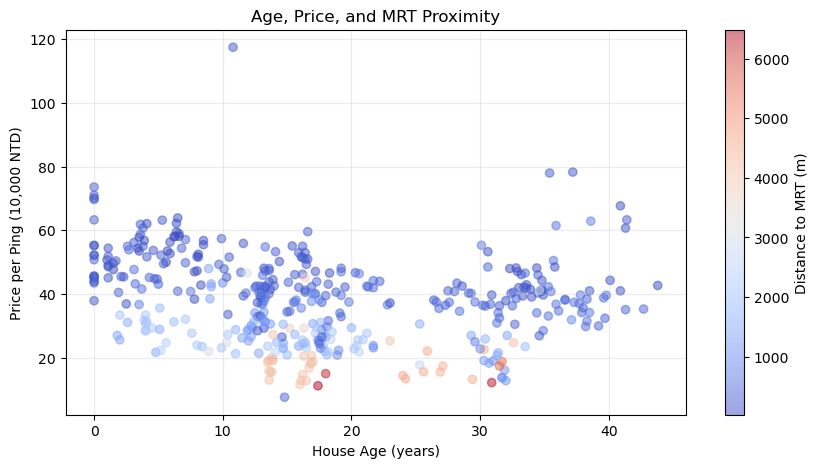

In [6]:
def plot_age_price_mrt(df):
    """
    This function takes in real estate data to return a 
    scatter plot of house age vs price, colored by MRT distance.
    """
    fig, ax = plt.subplots(figsize = (10, 5))
    scatter = ax.scatter(df['age_yrs'], df['price_ping'], c = df['mrt_m'], cmap = 'coolwarm', alpha = 0.5)
    plt.colorbar(scatter, label = 'Distance to MRT (m)')
    ax.set_xlabel('House Age (years)')
    ax.set_ylabel('Price per Ping (10,000 NTD)')
    ax.set_title('Age, Price, and MRT Proximity')
    ax.grid(True, alpha = 0.25)
    plt.show()
    return ax

ax = plot_age_price_mrt(df)
assert len(ax.collections) == 1, "Expected one scatter plot"
assert ax.get_xlabel() == 'House Age (years)', "x label mismatch"
assert ax.get_ylabel() == 'Price per Ping (10,000 NTD)', "y label mismatch"
assert ax.get_title() == 'Age, Price, and MRT Proximity', "title mismatch"

**Caption:** Older houses generally cost less, but MRT proximity helps maintain value even as properties age.

**Alt text:** Scatter plot with house age (0-45) on the x-axis and price on the y-axis. Points are colored by MRT distance. Dark red indicates farther, and dark blue indicates closer to MRT. Dark blue points concentrate in the upper left and show higher prices across ages, indicating that younger, closer houses cost more. Bright red points cluster mostly at lower prices, around ages 15-35 years.

**Brief paragraph:** This visualization addresses my second research question about whether age affects the MRT effect. I added color to show MRT distance with age and price. We can see that properties close to the MRT maintain higher prices even when they're older, whereas properties far from the MRT are consistently cheaper, regardless of age. This tells us that MRT proximity can help a property preserve its value.

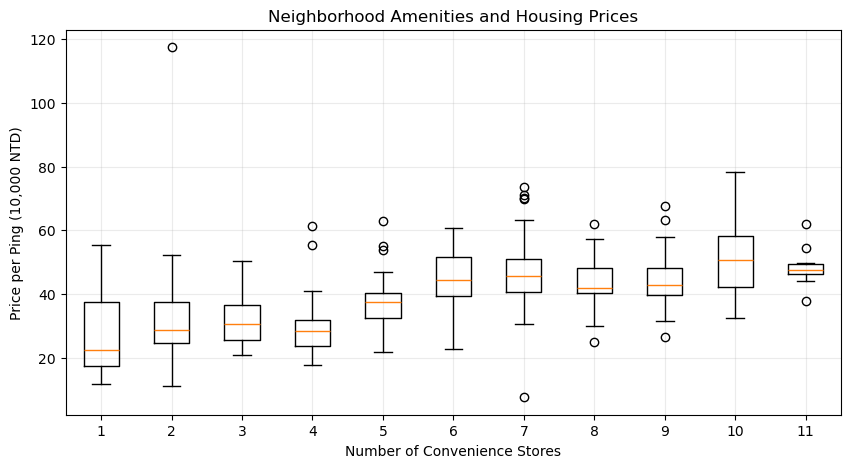

In [7]:
def plot_store_price_box(df):
    """
    This function takes in real estate data to return a 
    box plot of price vs number of nearby convenience stores.
    It returns (ax, bp) where bp is the dictionary from ax.boxplot.
    """
    fig, ax = plt.subplots(figsize = (10, 5))

    box_data = []
    for i in range(11):  # store counts 0..10
        box_data.append(df[df['stores'] == i]['price_ping'].values)

    bp = ax.boxplot(box_data)
    ax.set_xlabel('Number of Convenience Stores')
    ax.set_ylabel('Price per Ping (10,000 NTD)')
    ax.set_title('Neighborhood Amenities and Housing Prices')
    ax.grid(True, alpha = 0.25)
    plt.show()
    return ax, bp

ax, bp = plot_store_price_box(df)
assert len(bp['boxes']) == 11, "expected 11 boxes (0..10 stores)"
assert ax.get_xlabel() == 'Number of Convenience Stores', "x label mismatch"
assert ax.get_ylabel() == 'Price per Ping (10,000 NTD)', "y label mismatch"
assert ax.get_title() == 'Neighborhood Amenities and Housing Prices', "title mismatch"

**Caption:** Properties with more nearby convenience stores show higher median prices, suggesting commercial amenities add value to houses.

**Alt text:** Box plot showing price distributions for each count of nearby stores (0-11) on the x-axis. Median prices show variation but generally trend upward. The pattern isn't perfectly linear, and there are multiple outlier points (the circles above the boxes).

**Brief summary:** This plot addresses my third research question about how neighborhood amenities relate to housing prices. I used a box plot because the number of stores makes it easier to show the full price distribution at each level, rather than a scatter plot. The main thing is that more stores are associated with higher prices, and properties with more than 5 stores tend to have higher median prices than those with fewer stores.

## Implications and Limitations

Through this project, homebuyers and real estate professionals can gain a deeper understanding of the factors that may influence housing price fluctuations. However, people not living in these areas might find this less relevant, and it might even negatively impact housing prices in regions that didn't have such high prices to begin with. Though a bit of a stretch, this could potentially harm lower-income residents renting near public transportation. Data setting significantly helped me with visualization, since I compiled the rows and columns I used into a smaller, more relevant dataset. I also renamed the column names so it's easier to see what the results mean. In terms of limitations, this dataset has a small sample size and may miss other explanatory variables. It is also only relevant to one region in Taiwan, so the results of this project can't necessarily be applied to any other area's real estate price fluctuations. Also, this project only explores relations between variables, and does not stand to be any cause and effect situations. Based on these three limitations, the results should only be seen as mere patterns in the specific region of Taipei, and a stronger analysis on a larger dataset with more variables is needed to achieve concrete answers.

## Challenge Goals

**Challenge Goal 1: Statistical Hypothesis Testing**

I will use statistical hypothesis tests to validate my research findings. I'm going to use Pearson correlation tests to confirm that MRT distance significantly affects prices (p < 0.001), and compare how this effect varies between newer and older houses, and use a t-test to show that properties near more stores have significantly higher prices. 

**Challenge Goal 2: Advanced Machine Learning (XGBoost)**

I will use XGBoost to predict housing prices in the modeling phase. XGBoost isn't included in scikit-learn, but it's good at handling non-linear patterns, such as how the effect of MRT proximity might lessen with distance, or how age and MRT distance might have an effect on one another. 

**Changes from proposal:**

I originally planned to use Altair for interactive visualizations, but switched to statistical hypothesis testing instead. I made this change because the final deliverable is a PDF where interactive features wouldn't work anyway, and hypothesis testing provides stronger statistical evidence for my research questions.

## Plan Evaluation

My original time estimates were mostly accurate for the basic tasks, but I didn't account for everything. Data loading and cleaning: estimated 3 hours, took about 2 hours. The dataset had no missing values, so I didn't need to spend time dealing with that. Visualizations and interpretations: estimated 3-4 hours, took around 6 hours. I spent a lot of time making sure the plots looked good and writing detailed explanations for each one. 

**Why estimates were off:**

The clean data saved me time upfront, but I underestimated how long it takes to write explanations.

**Still need to do:**

- Statistical hypothesis testing: around 3 hours
- XGBoost modeling: around 4 hours
- Model evaluation: around 4 hours  
- Finalization: around 1 hour

## Testing

For my visualizations, I included docstrings under each function so readers can get a better gist of what the code does. I also included simple doctests under each function, which run every time the block of code is executed. Tests like checking the correct variable for the labels in my plot and determining how many boxes in the box plot are expected are examples of the tests I used. For the dataset itself, I checked for any issues that needed cleaning using the isnull() function. This dataset is trustworthy because it comes from UC Irvine and was collected a few years ago.